In [3]:
import torch
from torch import optim
import sys
from tqdm import tqdm
sys.path.append('../..')
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal, StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.base import CompositeTransform
import numpy as np

import torch

from torch.utils.tensorboard import SummaryWriter

import scripts.utils as utils
import scripts.plot as plot

train_y, train_x = utils.get_training_data()
test_y, test_x = utils.get_test_data()

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(39949, 10) (39949, 96) (11414, 10) (11414, 96)


[22303, 31804, 34812, 38305, 32415, 21484, 8519, 7996, 31577, 2395, 7986, 30707, 26760, 10739, 29147]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


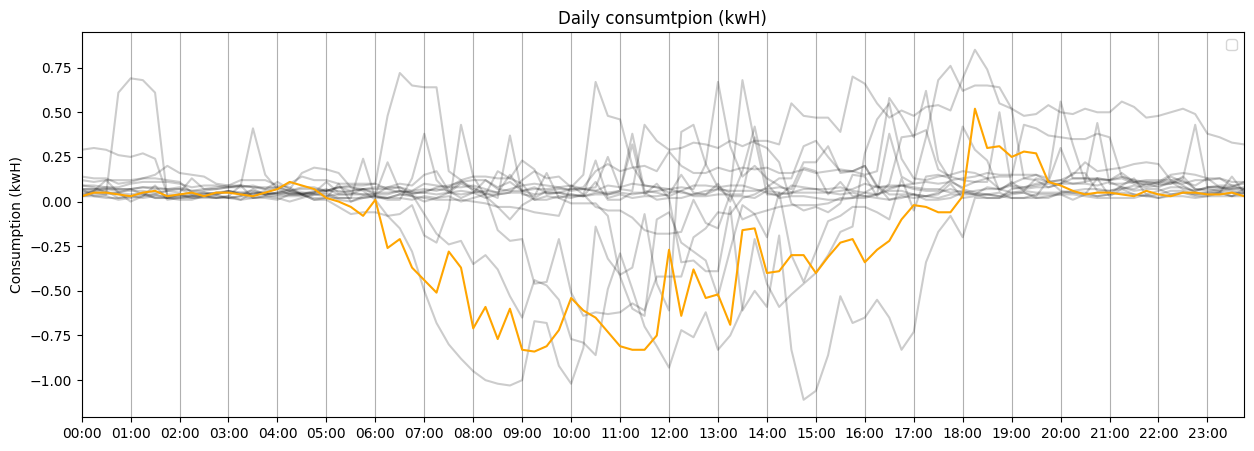

In [2]:
import random
randomlist = random.sample(range(0, len(train_y)), 15)
print(randomlist)
days_plot = []
for num in randomlist:
    days_plot.append(train_y[num])
plot.plotday(np.squeeze(days_plot));

In [4]:
from tqdm import tqdm

flow = torch.load(r'C:\Thesis\trash\NF\runs\run3\model-8000')
index = 1
original = test_y[index]
context = np.array([test_x[index]])
context = torch.from_numpy(context).to(torch.float).cuda()
# with torch.no_grad():
#     z = flow.sample(num_samples=10000, context=)

# days = z.squeeze().cpu().detach().numpy()

In [12]:
energy_scores = []
mse = []
mae = []
for org_sample,org_attribute in tqdm(zip(test_y,test_x)):
    with torch.no_grad():
        org_attribute = torch.from_numpy(np.array([org_attribute])).to(torch.float).cuda()
        z = flow.sample(num_samples=250, context=org_attribute)

    samples = z.squeeze().cpu().detach().numpy()
    samples = samples[~np.isnan(samples).any(axis=1)]
    probality_array = [1/len(samples)]*len(samples) #All have the same probability of occuring!
    energy_scores.append(utils.calculate_energy_score(probality_array,samples,org_sample))

    mae_temp = []
    mse_temp = []
    for s in samples:
        mae_temp.append(np.abs(org_sample - s))
        mse_temp.append(np.square(org_sample - s))
    mae.append(np.mean(mae_temp))
    mse.append(np.mean(mse_temp))

print(f'Energy scores | Median: {np.nanmedian(energy_scores):.3f}   Mean: {np.nanmean(energy_scores) :.3f} ')
print(f'MSE | Median: {np.nanmedian(mse):.3f}   Mean: {np.nanmean(mse) :.3f} ')
print(f'MAE | Median: {np.nanmedian(mae):.3f}   Mean: {np.nanmean(mae) :.3f} ')

22it [00:05,  4.47it/s]c:\Users\jankr\miniconda3\envs\NF\lib\site-packages\sklearn\metrics\pairwise.py:572: RuntimeWarning: overflow encountered in cast
  distances[x_slice, y_slice] = d.astype(np.float32, copy=False)
47it [00:10,  4.48it/s]c:\Users\jankr\miniconda3\envs\NF\lib\site-packages\sklearn\metrics\pairwise.py:572: RuntimeWarning: overflow encountered in cast
  distances[x_slice, y_slice] = d.astype(np.float32, copy=False)
244it [00:54,  4.44it/s]c:\Users\jankr\miniconda3\envs\NF\lib\site-packages\sklearn\metrics\pairwise.py:572: RuntimeWarning: overflow encountered in cast
  distances[x_slice, y_slice] = d.astype(np.float32, copy=False)
281it [01:03,  4.45it/s]


KeyboardInterrupt: 

In [13]:
print(f'Energy scores | Median: {np.nanmedian(energy_scores):.3f}   Mean: {np.nanmean(energy_scores) :.3f} ')
print(f'MSE | Median: {np.nanmedian(mse):.3f}   Mean: {np.nanmean(mse) :.3f} ')
print(f'MAE | Median: {np.nanmedian(mae):.3f}   Mean: {np.nanmean(mae) :.3f} ')

Energy scores | Median: 7.756   Mean: -inf 
MSE | Median: 0.652   Mean: 55696353529554541278222343116898255422507630922799761493164294144.000 
MAE | Median: 0.802   Mean: 112846531637125728725815525376.000 


In [16]:
def data_df_to_quantiles(data_df): 
    # q = np.concatenate([np.arange(0, 0.05, 0.01), np.arange(0.05, 0.96, 0.05), np.arange(0.95, 1.005, 0.01)])
    q = np.arange(0, 1.01, 0.025)
    quantiles = (
        data_df.quantile(q, interpolation = 'nearest')
        .set_axis((q*100).astype('int'), axis = 0)
    )
    lower_quantiles = quantiles.loc[:49, :].stack().to_frame('min').rename_axis(index = ['lower_quantile', 'timestamp'])
    upper_quantiles = quantiles.loc[51:, :].stack().to_frame('max').reset_index(level = 0).rename(columns = {'level_0':'upper_quantile'}).assign(lower_quantile = lambda x: 100-x.upper_quantile).set_index('lower_quantile', append = True).swaplevel(0,1).sort_index().rename_axis(index = ['lower_quantile', 'timestamp'])
    return lower_quantiles.join(upper_quantiles).reset_index().assign(quantiles = lambda x: x.lower_quantile.astype('str').str.zfill(2)+'-'+x.upper_quantile.astype('str').str.zfill(2)).drop(columns = ['lower_quantile', 'upper_quantile'])

import pandas as pd
df = pd.DataFrame(days.reshape(len(days),-1))
df['ID'] = 1
import altair as alt
plot_df = df.groupby('ID').apply(data_df_to_quantiles).droplevel(1).reset_index()

area_chart = alt.Chart(plot_df).mark_area().encode(
    x = 'timestamp', 
    y= alt.Y('min:Q',title = 'consumption (kWh)',axis = alt.Axis(format = '.2f')),  
    y2='max:Q', 
    color= 'quantiles:O',    
    column = alt.Column('ID',  header=alt.Header(labelFontSize=15))
).properties(width=500,height=500).resolve_scale(y = 'shared').resolve_axis(y= 'independent').interactive(bind_x = False).configure_legend(labelLimit= 0)
area_chart

alt.Chart(...)

In [13]:
from tqdm import tqdm
flow = torch.load('./runs/run3/model-4000')

scores_training = []
for index in tqdm(range(2)):
    original = test_y[index]
    context = np.array([test_x[index]])
    context = torch.from_numpy(context).to(torch.float).cuda()
    with torch.no_grad():
        z = flow.sample(num_samples=250,context=context)

    days = z.squeeze().cpu().numpy()
    days = days[~np.isnan(days).any(axis=1)]
    # scores_training.append(calculate_energy_score([1/len(days)]*len(days),days,test_y[index].cpu().numpy()))

100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


In [ ]:
from tqdm import tqdm
flow = torch.load('./runs/run2/model-5000')

scores = []
for index in tqdm(range(500)):
    original = test_y[index].cpu().numpy()
    num_arrays = np.random.choice(test_y.cpu().numpy().shape[0], size=250, replace=False)
    sample_indices = np.random.choice(num_arrays, size=250, replace=False)
    days = np.take(test_y.cpu().numpy(), sample_indices, axis=0)

    scores.append(calculate_energy_score([1/len(days)]*len(days),days,original))